In [2]:
import os
import random
import time
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
# from skimage import io, transform

from torch import nn, optim

from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

# from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

In [11]:
if(os.path.isfile('./images/image3/train2/noise_train/.DS_Store')):
    os.remove('./images/image3/train2/noise_train/.DS_Store')
    
if(os.path.isfile('./images/image2/val/noise_val/.DS_Store')):
    os.remove('./images/image2/val/noise_val/.DS_Store')
    

In [12]:
IMAGE_SIZE = 96  # 画像の読み込みサイズ
EMBED_SIZE = 128  # 潜在変数zの次元数
BATCH_SIZE = 8  # バッチサイズ
EPOCHS = 300  # エポック数
gLR = 0.0004 # 学習率
dLR = 0.00004

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが使えるならGPUで、そうでないならCPUで計算する
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  

In [14]:
COLAB_FLG = False

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter8"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    

SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1/image/image_from_z/"  # 乱数から生成した画像の保存先
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/EfficientGAN_L1/image/RECONSTRUCT/"  # 再構成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

In [15]:
train_root = './images/image3/train2/noise_train'  # train dataの保存してあるディレクトリ
val_root = './images/image2/val/noise_val'  # val dataの保存してあるディレクトリ

In [16]:
# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [17]:
# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.CenterCrop(225),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            # transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.CenterCrop(225),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
    "test2": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
}

In [18]:
# 読み込む

train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

val_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2), #48x48
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), #24x24

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), #12x12
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2), #6x6

        
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1

            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1
        )
        
        self.last = nn.Sequential(
            nn.Conv2d(512, EMBED_SIZE, kernel_size=1, stride=1, bias=False)
        )


    def forward(self, x):
        
        out = self.main(x)

        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),

            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(256, 256, kernel_size=6, stride=1) #1x1

        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(EMBED_SIZE, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
            

            
        )
        
        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
            
            
 
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):
        
        output_x = self.x_layer(x)
        output_z = self.z_layer(z)
        
        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)
        
        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [22]:
# 重みの初期化を行う関数


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

In [23]:
model_E = Encoder().to(device)
model_E.apply(weights_init)

model_G = Generator().to(device)
model_G.apply(weights_init)

model_D = Discriminator().to(device)
model_D.apply(weights_init)

criterion = nn.BCELoss()
criterion_L1 = nn.L1Loss(reduction="sum")  # L1 lossも学習時に用いる

optimizer_ge = torch.optim.Adam(list(model_G.parameters()) + list(model_E.parameters()), lr= gLR, betas=(0.5,0.999))
optimizer_d = torch.optim.Adam(model_D.parameters(), lr= dLR,betas=(0.5,0.999))
scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

In [24]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = model_D(x, E_x)
    _,G_E_x_feature = model_D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss

In [25]:
loss_d_list, loss_ge_list, anomaly_score_list = [], [], []

start = time.time()
for epoch in range(EPOCHS):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        model_G.train()
        model_D.train()
        model_E.train()
        # set values
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).to(device)
        
        # noise for discriminator
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)

        # discriminator
        optimizer_d.zero_grad()
        
        E_x = model_E(x) 
        p_true, _ = model_D(x + noise1, E_x)
        
        G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # generator and encoder
        optimizer_ge.zero_grad()
        
        G_E_x = model_G(E_x)
        E_G_z = model_E(G_z)
    
        p_true, _ = model_D(x + noise1, E_x)
        
        # G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        
        loss_ge_1 = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge_2 = criterion_L1(x, G_E_x) +  criterion_L1(z, E_G_z)
        
        alpha = 0.01
        
        loss_ge = (1 - alpha)*loss_ge_1 + alpha*loss_ge_2
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # record anomaly score
        
        model_G.eval()
        model_D.eval()
        model_E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = model_E(x_val)
        G_E_x_val = model_G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)

            
        # save images
        if i == 0:
            
            model_G.eval()
            model_D.eval()
            model_E.eval()
        
            save_image_size_for_z = min(BATCH_SIZE, 8)
            save_images = model_G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(BATCH_SIZE, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = model_G(model_E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # record loss
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{EPOCHS} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    loss_d_list.append(loss_d_mean)
    loss_ge_list.append(loss_ge_mean)
    anomaly_score_list.append(anomaly_score_mean)
    
    # save model
    if (epoch + 1) % 10 == 0:
        torch.save(model_G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch + 1}.pkl')
        torch.save(model_E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch + 1}.pkl')
        torch.save(model_D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch + 1}.pkl')
        
end = time.time()
print(end-start)

0/300 epoch ge_loss: 22.070 d_loss: 0.115 anomaly_score: 2263.086
1/300 epoch ge_loss: 9.331 d_loss: 0.110 anomaly_score: 930.848
2/300 epoch ge_loss: 8.038 d_loss: 0.104 anomaly_score: 738.662
3/300 epoch ge_loss: 7.416 d_loss: 0.093 anomaly_score: 640.517
4/300 epoch ge_loss: 7.031 d_loss: 0.079 anomaly_score: 601.032
5/300 epoch ge_loss: 6.668 d_loss: 0.066 anomaly_score: 576.805
6/300 epoch ge_loss: 6.392 d_loss: 0.055 anomaly_score: 551.126
7/300 epoch ge_loss: 6.248 d_loss: 0.051 anomaly_score: 528.257
8/300 epoch ge_loss: 6.143 d_loss: 0.045 anomaly_score: 517.638
9/300 epoch ge_loss: 6.062 d_loss: 0.041 anomaly_score: 509.460
10/300 epoch ge_loss: 5.914 d_loss: 0.035 anomaly_score: 495.219
11/300 epoch ge_loss: 5.851 d_loss: 0.031 anomaly_score: 493.359
12/300 epoch ge_loss: 5.822 d_loss: 0.029 anomaly_score: 484.002
13/300 epoch ge_loss: 5.698 d_loss: 0.026 anomaly_score: 481.914
14/300 epoch ge_loss: 5.741 d_loss: 0.025 anomaly_score: 477.028
15/300 epoch ge_loss: 5.548 d_los

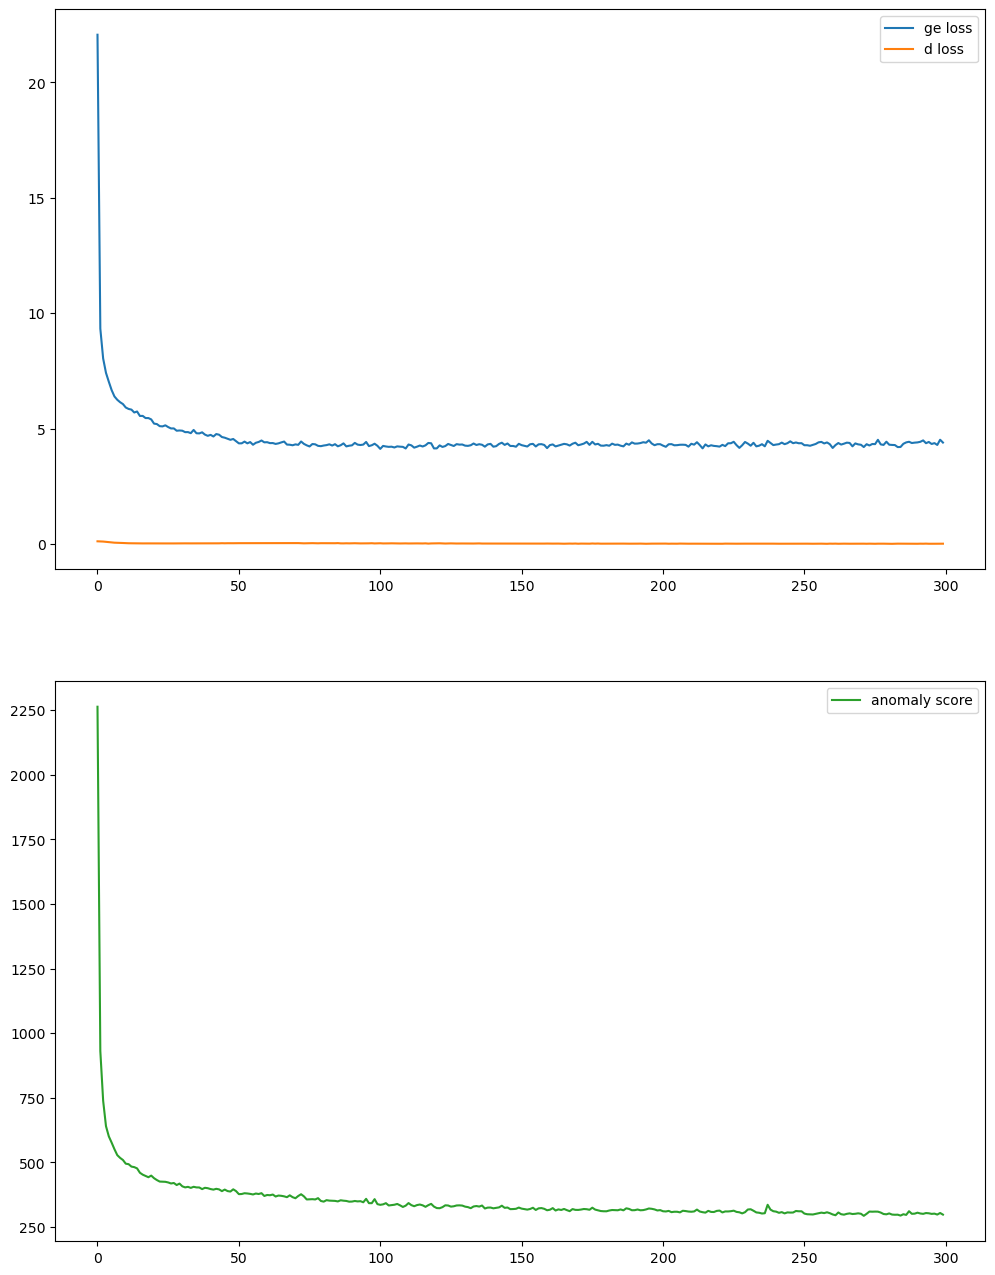

In [26]:
plt.figure(figsize=(12, 8*2))
plt.subplot(211)
plt.plot(range(len(loss_ge_list)), loss_ge_list, label="ge loss",color="C0")
plt.legend()

plt.plot(range(len(loss_d_list)), loss_d_list, label="d loss",color="C1")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_score_list)), anomaly_score_list, label="anomaly score",color="C2")
plt.legend()
# plt.ylim(0, 10000)

plt.show()

In [27]:
LOAD_EPOCH = 300

model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
model_G.eval()

model_E = Encoder().to(device)
model_E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
model_E.eval()

model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
model_D.eval()

print("load model")

load model


In [28]:
if(os.path.isfile('./images/image2/test2/signal_test/.DS_Store')):
    os.remove('./images/image2/test2/signal_test/.DS_Store')

In [29]:
import csv
x = []
y = []
file = open('./csv/signal_test.csv', 'r')
data = csv.reader(file)
for row in data:
    x.append(row[0])
    y.append(float(row[1]))
file.close()

In [30]:
random_image_size = 1000

test_root_normal = './images/image2/test2/signal_test'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)
anoma = []
start = time.time()
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    anoma.append(loss)
# if loss>=630:
    '''diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    print(y[idx])
    print(idx)
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(joined_image,aspect =0.6)
        # plt.subplots_adjust(left=0, right=1, bottom=0.01, top=0.99)
    plt.savefig('./images/result/{}'.format(idx))
    plt.show()'''
    
end = time.time()
print(end-start)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


25.87837815284729


In [46]:
import csv
list1=[]
index1 = []
for i in range(len(anoma)):
    if anoma[i]<=620:
        list1.append(anoma[i])
        index1.append(i)
print(len(list1))
print(list1)


z = []
for i in range(len(index1)):
    z.append(y[index1[i]])
    
# print(anoma)

39
[605.722900390625, 587.1870727539062, 617.1265869140625, 615.5081176757812, 618.5625610351562, 613.3119506835938, 606.8247680664062, 618.6341552734375, 618.234130859375, 613.5667114257812, 601.5686645507812, 587.2974243164062, 618.2901611328125, 611.4866943359375, 610.3754272460938, 588.6066284179688, 604.7208862304688, 605.740478515625, 591.5807495117188, 588.7548217773438, 618.9783935546875, 610.6871948242188, 598.4779663085938, 598.8602905273438, 607.9346313476562, 612.3760986328125, 593.0177001953125, 619.5901489257812, 607.3701171875, 588.7048950195312, 614.1156616210938, 601.8558349609375, 610.44970703125, 612.8806762695312, 613.9253540039062, 602.4173583984375, 615.4840698242188, 589.697021484375, 592.67919921875]


In [35]:
if(os.path.isfile('./images/image2/test2/noise_test/.DS_Store')):
    os.remove('./images/image2/test2/noise_test/.DS_Store')

In [36]:
random_image_size = 1000
start = time.time()
test_root_normal = './images/image2/test2/noise_test'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)
anoma2 = []
start = time.time()
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    anoma2.append(loss)
    # '''if loss >=800:
    '''diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    print(idx)
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.axis('off')
    plt.imshow(joined_image,aspect=0.6)
    plt.savefig('./images/result3/{}'.format(idx))
    plt.show()'''
    
end = time.time()
print(end-start)

23.86013412475586


In [45]:
list2=[]
for i in range(len(anoma2)):
    if anoma2[i]>620:
        list2.append(anoma2[i])
print(len(list2))
print(list2)
        

66
[650.2809448242188, 751.8851318359375, 620.5494384765625, 746.4497680664062, 955.65234375, 985.269287109375, 634.4237670898438, 684.768310546875, 643.6630859375, 630.256591796875, 668.5476684570312, 939.81494140625, 629.8896484375, 642.78466796875, 657.3228149414062, 880.8170776367188, 641.3167114257812, 662.4848022460938, 626.2410888671875, 738.1044311523438, 645.5833740234375, 696.3411865234375, 688.4611206054688, 651.8043823242188, 674.8594970703125, 644.8522338867188, 668.009521484375, 749.0404052734375, 629.943359375, 1031.267333984375, 719.8102416992188, 645.4911499023438, 654.8121337890625, 874.330322265625, 772.5545654296875, 974.616943359375, 643.7752075195312, 789.8732299804688, 718.9644775390625, 640.349365234375, 635.8675537109375, 647.1478881835938, 670.1652221679688, 707.6079711914062, 640.865478515625, 627.7846069335938, 723.9879760742188, 645.0918579101562, 989.7077026367188, 633.1934204101562, 651.0560302734375, 874.218505859375, 639.3546752929688, 951.84912109375, 

2000
2000


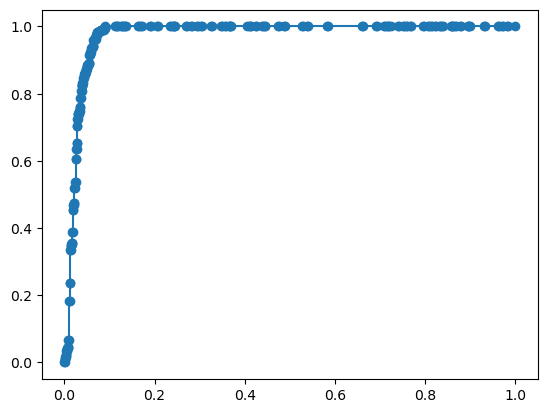

0.974071


In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

ans1 = [1]*1000
anslist2 = [0]*1000
ans1.extend(anslist2)
print(len(ans1))
pre1 = anoma + anoma2
print(len(pre1))
fpr1, tpr1, thresholds1 = roc_curve(ans1, pre1)
plt.plot(fpr1, tpr1, marker='o')
# plt.ylim(0.6,1.05)
plt.show()

print(roc_auc_score(ans1, pre1))
# 0.6875


In [41]:
pred = []
for i in range(len(pre1)):
    if pre1[i]>=620:
        pred.append(1)
    else:
        pred.append(0)

In [42]:
print(f1_score(ans1, pred))

0.9481993093241242


In [41]:
if(os.path.isfile('./images/image2/test2/signal_test/.DS_Store')):
    os.remove('./images/image2/test2/signal_test/.DS_Store')

In [42]:
random_image_size = 1000

test_root_normal = './images/image2/test2/signal_test'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)
anoma = []
start = time.time()
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    anoma.append(loss)
    '''if loss>=630:
        diff_img = torch.abs(x - G_E_x)
        print(f"Anomaly_score: {loss:.3f}")
        print(y[idx])
        print(idx)
        comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
        joined_image = make_grid(comparison, nrow=3).detach().numpy()
        joined_image = np.transpose(joined_image, [1, 2, 0])
        plt.figure(figsize=(12,10))
        plt.axis('off')
        plt.imshow(joined_image,aspect=0.6)
        # plt.subplots_adjust(left=0, right=1, bottom=0.01, top=0.99)
        # plt.savefig('./image{}'.format(idx),facecolor="azure")
        plt.show()'''
    
end = time.time()
print(end-start)

26.429447889328003


In [43]:
if(os.path.isfile('./images/image2/test/noise_test/.DS_Store')):
    os.remove('./images/image2/test/noise_test/.DS_Store')

In [44]:
random_image_size = 1000
start = time.time()
test_root_normal = './images/image2/test/noise_test'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)
anoma2 = []
start = time.time()
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    anoma2.append(loss)
    '''if loss >=800:
        diff_img = torch.abs(x - G_E_x)
        print(f"Anomaly_score: {loss:.3f}")
        comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
        joined_image = make_grid(comparison, nrow=3).detach().numpy()
        joined_image = np.transpose(joined_image, [1, 2, 0])
    
        plt.figure(figsize=(12, 4))
        plt.imshow(joined_image)
        plt.show()'''
    
end = time.time()
print(end-start)

22.224679231643677


2000
2000


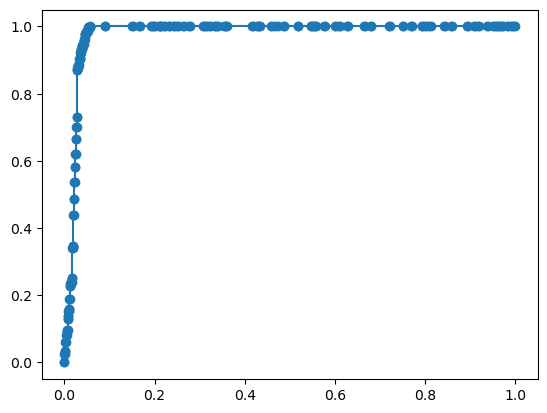

In [45]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

ans1 = [1]*1000
anslist2 = [0]*1000
ans1.extend(anslist2)
print(len(ans1))
pre1 = anoma + anoma2
print(len(pre1))
fpr1, tpr1, thresholds1 = roc_curve(ans1, pre1)
plt.plot(fpr1, tpr1, marker='o')
# plt.ylim(0.6,1.05)
plt.show()

In [46]:
import csv
list1=[]
index1 = []
for i in range(len(anoma)):
    if anoma[i]<=600:
        list1.append(anoma[i])
        index1.append(i)
print(len(list1))
print(list1)


z = []
for i in range(len(index1)):
    z.append(y[index1[i]])
    


55
[583.1679077148438, 594.9677124023438, 595.9646606445312, 595.1494750976562, 578.7056884765625, 582.346435546875, 574.586669921875, 596.0697021484375, 574.1060180664062, 593.694091796875, 587.2571411132812, 575.2312622070312, 588.9959716796875, 598.7169799804688, 596.85546875, 584.0115966796875, 593.8074951171875, 589.931640625, 598.3709716796875, 581.4134521484375, 593.0992431640625, 575.5615234375, 592.9212036132812, 566.8692016601562, 585.631591796875, 584.7621459960938, 588.570068359375, 586.6483764648438, 577.1193237304688, 595.6959838867188, 584.5046997070312, 574.699462890625, 583.4888916015625, 577.6718139648438, 576.1884765625, 597.19384765625, 594.5305786132812, 576.773681640625, 579.8095703125, 573.3070678710938, 596.7344360351562, 591.256591796875, 599.3296508789062, 598.7999877929688, 592.6680908203125, 570.1145629882812, 563.29931640625, 582.7583618164062, 594.25390625, 578.8074951171875, 594.17333984375, 594.0142822265625, 596.8450927734375, 591.9498291015625, 589.696

In [47]:
list2=[]
for i in range(len(anoma2)):
    if anoma2[i]>=600:
        list2.append(anoma2[i])
print(len(list2))
print(list2)
        

40
[799.7243041992188, 655.4937133789062, 774.6500854492188, 679.732421875, 605.95751953125, 835.6394653320312, 883.1441650390625, 603.9815063476562, 701.9681396484375, 934.572265625, 880.0881958007812, 609.3154907226562, 739.4957885742188, 602.50439453125, 768.6915283203125, 841.4881591796875, 616.845458984375, 868.4566650390625, 689.3124389648438, 616.9207153320312, 600.4695434570312, 601.5914916992188, 671.0460815429688, 826.4015502929688, 662.0651245117188, 820.4309692382812, 610.4962158203125, 649.6924438476562, 772.5728759765625, 741.6807250976562, 868.2054443359375, 909.7489624023438, 776.2389526367188, 740.8640747070312, 620.998046875, 778.3179321289062, 712.0767211914062, 618.0144653320312, 952.9306640625, 619.2184448242188]


In [55]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import japanize_matplotlib

import random
torch.manual_seed(12)
np.random.seed(12)
random.seed(12)

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.CenterCrop(225),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

torch.Size([3, 32, 32])
6000


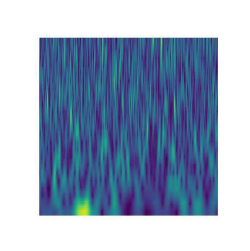

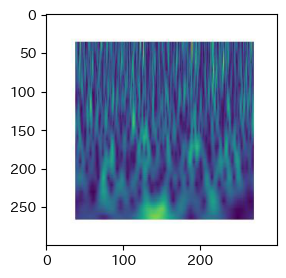

'image3,label3 = train_dataset[0]\np = torchvision.transforms.functional.to_pil_image(image1)\nplt.imshow(p)'

In [57]:
from pathlib import Path
train_image_dir = './images/image3/train'
val_image_dir = './images/image2/val'
test_image_dir = './images/image2/test2'
# gw_image_dir = './cnnregression/effspinimage/GW150914'

train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transform)
validation_dataset = torchvision.datasets.ImageFolder(root=val_image_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_image_dir, transform=transform)
# gw_dataset = torchvision.datasets.ImageFolder(root=gw_image_dir, transform=transform)

image1,label1 = train_dataset[0]
print(image1.shape)

dataset = torchvision.datasets.ImageFolder(root=train_image_dir)
image,label = dataset[1003]
image2,label2 = dataset[0]
print(len(dataset))
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(image)
plt.show()
plt.figure(figsize=(3,3))
# plt.axis('off')
plt.imshow(image2)
plt.show()

'''image3,label3 = train_dataset[0]
p = torchvision.transforms.functional.to_pil_image(image1)
plt.imshow(p)'''

In [115]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# gw_dataloader = DataLoader(gw_dataset, batch_size=32, shuffle=False)

In [116]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [117]:
model = CNN(2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [118]:
import time
num_epocs = 30
losses = []
accs = []
val_losses = []
val_accs = []
time_sta = time.time()
for epoch in range(num_epocs):
    # 学習
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    # 検証
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}    " \
    "val_epoch: {}, val_loss: {}, val_acc: {}".format(epoch, running_loss, running_acc, epoch, val_running_loss, val_running_acc)) 
time_end = time.time()
tim = time_end- time_sta
print(tim)

epoch: 0, loss: 0.15137419993605247, acc: 0.930518627166748    val_epoch: 0, val_loss: 0.020331087594146743, val_acc: 0.9890872836112976
epoch: 1, loss: 0.01690837573914905, acc: 0.9946808218955994    val_epoch: 1, val_loss: 0.01752046663891597, val_acc: 0.9920634627342224
epoch: 2, loss: 0.008648335304340367, acc: 0.9971742033958435    val_epoch: 2, val_loss: 0.0022675895521494004, val_acc: 0.9980158805847168
epoch: 3, loss: 0.0028854220188071983, acc: 0.9996675252914429    val_epoch: 3, val_loss: 0.0013646142027043105, val_acc: 1.0
epoch: 4, loss: 0.003432764296702133, acc: 0.9990026354789734    val_epoch: 4, val_loss: 0.006061105809469622, val_acc: 0.9960317611694336
epoch: 5, loss: 0.008374400279127437, acc: 0.9973404407501221    val_epoch: 5, val_loss: 0.002293466497297255, val_acc: 0.9990079402923584
epoch: 6, loss: 0.0008636593840669002, acc: 1.0    val_epoch: 6, val_loss: 0.0014348409234285653, val_acc: 1.0
epoch: 7, loss: 0.0011549424229682932, acc: 1.0    val_epoch: 7, val_lo

In [119]:
#test2 5~40 5000 images5000 #2000枚
test_running_loss = 0.0
test_running_acc = 0.0
test_losses =[]
test_accs = []
pre2 = []
ans2 = []
pre3 = []
start = time.time()
for test_imgs, test_labels in test_dataloader:
    test_imgs = test_imgs.to(device)
    test_labels = test_labels.to(device)
    test_output = model(test_imgs)
    
    list1 = test_output.tolist()
    for i in range(len(list1)):
        pre2.append(list1[i][1])
    loss = criterion(test_output, test_labels)
    list2 = test_labels.tolist()
    for j in range(len(list2)):
        ans2.append(list2[j])
    test_loss = criterion(test_output, test_labels)
    test_running_loss += test_loss.item()
    test_pred = torch.argmax(test_output, dim=1)
    list3 = test_pred.tolist()
    for k in range(len(list3)):
        pre3.append(list3[i])
    
    test_running_acc += torch.mean(test_pred.eq(test_labels).float())
test_running_loss /= len(test_dataloader)
test_running_acc /= len(test_dataloader)
test_losses.append(test_running_loss)
test_accs.append(test_running_acc)
print("test_loss: {}, test_acc: {}".format(test_running_loss, test_running_acc))
end = time.time()
print(end-start)

test_loss: 0.0008907868682260904, test_acc: 1.0
7.095810174942017


In [1]:
import pandas as pd
fn=0
fp=0
tp=0
tn=0
for i in range(len(pre3)):
    if pre3[i]==0 and ans2[i]==1:
        fn+=1
    if pre3[i]==1 and ans2[i]==0:
        fp+=1
    if pre3[i]==1 and ans2[i]==1:
        tp+=1
    if pre3[i]==0 and ans2[i]==0:
        tn+=1

list=[[tp,fp],[fn,tn]]
ind = ['重力波ありと予測','重力波なしと予測']
col = ['重力波あり','重力波なし']

df = pd.DataFrame(list, index=ind, columns=col)
df

NameError: name 'pre3' is not defined

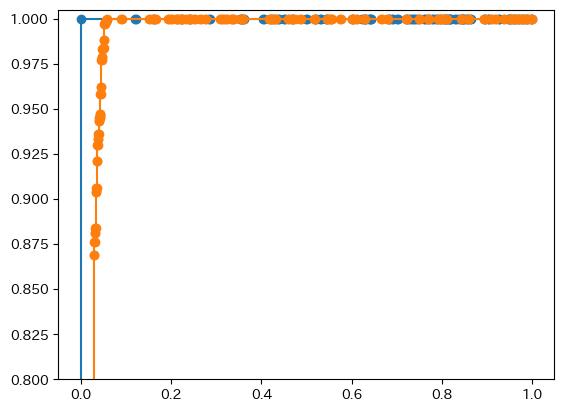

0.978717
1.0


In [121]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
fpr2, tpr2, thresholds2 = roc_curve(ans2, pre2)
plt.plot(fpr2, tpr2, marker='o')
plt.plot(fpr1, tpr1, marker='o')
plt.ylim(0.8,1.005)
plt.show()

print(roc_auc_score(ans1, pre1))
print(roc_auc_score(ans2, pre2))